# Analyse correlation between adapter training data difference and performance

In order to make sure that the relative contribution adapters provide does not only depend on the relative datasize of languages, I set out to track the correlation between datasize difference between languages, and the performance change in terms of percentages compared to the **target-lang** experimental setup.

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api
import statsmodels.formula.api

plt.style.use("seaborn")

## Load file and preprocess it for percentage change

In [2]:
# function to calculate percentage change between columns

def percentage_change(col1, col2):
    return round(((col2 - col1)/ col1) * 100, 2)

In [3]:
# load and process the file

path_to_scores = "..outputs/all_results/accuracy.csv"
scores_df = pd.read_csv(path_to_scores, sep=";", index_col=0)

scores_df["low_ttr_percentage"] = percentage_change(scores_df["target-lang"], scores_df["low-ttr"])
scores_df["high_ttr_percentage"] = percentage_change(scores_df["target-lang"], scores_df["high-ttr"])
scores_df["low_mattr_percentage"] = percentage_change(scores_df["target-lang"], scores_df["low-mattr"])
scores_df["high_mattr_percentage"] = percentage_change(scores_df["target-lang"], scores_df["high-mattr"])


# filter for only the percentage colums
scores_df = scores_df.iloc[:, 6:]
scores_df

,low_ttr_percentage,high_ttr_percentage,low_mattr_percentage,high_mattr_percentage
amh,16.22,1.80,-5.41,-25.23
chm,-33.12,-2.60,-43.51,25.32
fra,-51.51,-8.30,-56.98,-76.79
hun,-69.20,-18.75,-56.03,-16.74
ind,-60.42,-9.11,-42.73,-61.47
isl,-22.80,4.15,-48.70,-56.74
sme,-23.56,2.62,-0.52,16.75
vie,-12.06,-16.72,-45.98,-57.72


## Collect datasizes in a dataframe

Datasizes are collected in terms of total Wikipedia word count.

In [4]:
datasize_dict_words = {
    "amh": 1_741_231, "chm": 2_649_872, "fra": 1_517_586_436,
    "hun": 200_574_595, "ind": 172_505_132, "isl": 12_160_596,
    "sme": 690_449, "vie": 304_141_969, "arb": 365_082_418,
    "mya": 19_810_317, "eng": 4_139_632_772, "est": 52_729_523,
    "fin": 149_186_378, "myv": 1_512_470, "deu": 1_419_295_552,
    "spa": 1_046_780_782, "kor": 146_150_008, "rus": 919_643_688,
    "ilo": 3_303_001, "ell": 125_956_087, "hya": 95_100_252,
    "wol": 658_856
}

In [5]:
sorted(datasize_dict_words, key=datasize_dict_words.get, reverse=True)

['eng',
 'fra',
 'deu',
 'spa',
 'rus',
 'arb',
 'vie',
 'hun',
 'ind',
 'fin',
 'kor',
 'ell',
 'hya',
 'est',
 'mya',
 'isl',
 'ilo',
 'chm',
 'amh',
 'myv',
 'sme',
 'wol']

In [97]:
# add relevant languages codes to settings
scores_df.rename((lambda x: x.rstrip("percentage")), axis="columns", inplace=True)
scores_df.rename((lambda x: x.rstrip("_")), axis="columns", inplace=True)

scores_df["low_ttr_language"] = [
    "arb", "est", "deu", "fin", "wol", "ilo", "chm", "eng"
]
scores_df["high_ttr_language"] = [
    "vie", "vie", "vie", "vie", "vie", "vie", "vie", "mya"
]
scores_df["low_mattr_language"] = [
    "mya", "myv", "spa", "rus", "fra", "ell", "hya", "ilo"
]
scores_df["high_mattr_language"] = [
    "eng", "eng", "kor", "eng", "kor", "kor", "eng", "kor"
]

scores_df["same_script_low_ttr"] = [
    "NO", "NO", "YES", "YES", "YES", "YES", "NO", "YES"
]
scores_df["same_script_high_ttr"] = [
    "NO", "NO", "YES", "YES", "YES", "YES", "YES", "NO"
]
scores_df["same_script_low_mattr"] = [
    "NO", "YES", "YES", "NO", "YES", "NO", "NO", "YES"
]
scores_df["same_script_high_mattr"] = [
    "NO", "NO", "NO", "YES", "NO", "NO", "YES", "NO"
]

In [98]:
scores_df

,low,high,low_m,high_m,low_ttr_langu,high_ttr_langu,low_mattr_langu,high_mattr_langu,src_language_sizes,low_ttr_sizes,...,diff_src_low_m,diff_src_high_m,low_ttr_language,high_ttr_language,low_mattr_language,high_mattr_language,same_script_low_ttr,same_script_high_ttr,same_script_low_mattr,same_script_high_mattr
amh,16.22,1.80,-5.41,-25.23,arb,vie,mya,eng,1741231,365082418,...,18069086,4137891541,arb,vie,mya,eng,NO,NO,NO,NO
chm,-33.12,-2.60,-43.51,25.32,est,vie,myv,eng,2649872,52729523,...,-1137402,4136982900,est,vie,myv,eng,NO,NO,YES,NO
fra,-51.51,-8.30,-56.98,-76.79,deu,vie,spa,kor,1517586436,1419295552,...,-470805654,-1371436428,deu,vie,spa,kor,YES,YES,YES,NO
hun,-69.20,-18.75,-56.03,-16.74,fin,vie,rus,eng,200574595,149186378,...,719069093,3939058177,fin,vie,rus,eng,YES,YES,NO,YES
ind,-60.42,-9.11,-42.73,-61.47,wol,vie,fra,kor,172505132,658856,...,1345081304,-26355124,wol,vie,fra,kor,YES,YES,YES,NO
isl,-22.80,4.15,-48.70,-56.74,ilo,vie,ell,kor,12160596,3303001,...,113795491,133989412,ilo,vie,ell,kor,YES,YES,NO,NO
sme,-23.56,2.62,-0.52,16.75,chm,vie,hya,eng,690449,2649872,...,94409803,4138942323,chm,vie,hya,eng,NO,YES,NO,YES
vie,-12.06,-16.72,-45.98,-57.72,eng,mya,ilo,kor,304141969,4139632772,...,-300838968,-157991961,eng,mya,ilo,kor,YES,NO,YES,NO


In [12]:
src_language_sizes = []
low_ttr_sizes = []
high_ttr_sizes = []
low_mattr_sizes = []
high_mattr_sizes = []

for idx, row in scores_df.iloc[:, 4:].iterrows():
    
    src_language_size = datasize_dict_words[idx]
    low_ttr_size = datasize_dict_words[row["low_ttr_language"]]
    high_ttr_size = datasize_dict_words[row["high_ttr_language"]]
    low_mattr_size = datasize_dict_words[row["low_mattr_language"]]
    high_mattr_size = datasize_dict_words[row["high_mattr_language"]]
    
    src_language_sizes.append(src_language_size)
    low_ttr_sizes.append(low_ttr_size)
    high_ttr_sizes.append(high_ttr_size)
    low_mattr_sizes.append(low_mattr_size)
    high_mattr_sizes.append(high_mattr_size)
    
print(high_mattr_sizes)

[4139632772, 4139632772, 146150008, 4139632772, 146150008, 146150008, 4139632772, 146150008]


In [13]:
# add these values to the columns

scores_df["src_language_sizes"] = src_language_sizes
scores_df["low_ttr_sizes"] = low_ttr_sizes
scores_df["high_ttr_sizes"] = high_ttr_sizes
scores_df["low_mattr_sizes"] = low_mattr_sizes
scores_df["high_mattr_sizes"] = high_mattr_sizes
scores_df

,low_ttr,high_ttr,low_mattr,high_mattr,low_ttr_language,high_ttr_language,low_mattr_language,high_mattr_language,src_language_sizes,low_ttr_sizes,high_ttr_sizes,low_mattr_sizes,high_mattr_sizes
amh,16.22,1.80,-5.41,-25.23,arb,vie,mya,eng,1741231,365082418,304141969,19810317,4139632772
chm,-33.12,-2.60,-43.51,25.32,est,vie,myv,eng,2649872,52729523,304141969,1512470,4139632772
fra,-51.51,-8.30,-56.98,-76.79,deu,vie,spa,kor,1517586436,1419295552,304141969,1046780782,146150008
hun,-69.20,-18.75,-56.03,-16.74,fin,vie,rus,eng,200574595,149186378,304141969,919643688,4139632772
ind,-60.42,-9.11,-42.73,-61.47,wol,vie,fra,kor,172505132,658856,304141969,1517586436,146150008
isl,-22.80,4.15,-48.70,-56.74,ilo,vie,ell,kor,12160596,3303001,304141969,125956087,146150008
sme,-23.56,2.62,-0.52,16.75,chm,vie,hya,eng,690449,2649872,304141969,95100252,4139632772
vie,-12.06,-16.72,-45.98,-57.72,eng,mya,ilo,kor,304141969,4139632772,19810317,3303001,146150008


In [14]:
# calculate differences between values

scores_df["diff_src_low_ttr"] =  scores_df["low_ttr_sizes"] - scores_df["src_language_sizes"]
scores_df["diff_src_high_ttr"] =  scores_df["high_ttr_sizes"] - scores_df["src_language_sizes"]
scores_df["diff_src_low_mattr"] = scores_df["low_mattr_sizes"] - scores_df["src_language_sizes"]
scores_df["diff_src_high_mattr"] = scores_df["high_mattr_sizes"] - scores_df["src_language_sizes"]
scores_df

,low_ttr,high_ttr,low_mattr,high_mattr,low_ttr_language,high_ttr_language,low_mattr_language,high_mattr_language,src_language_sizes,low_ttr_sizes,high_ttr_sizes,low_mattr_sizes,high_mattr_sizes,diff_src_low_ttr,diff_src_high_ttr,diff_src_low_mattr,diff_src_high_mattr
amh,16.22,1.80,-5.41,-25.23,arb,vie,mya,eng,1741231,365082418,304141969,19810317,4139632772,363341187,302400738,18069086,4137891541
chm,-33.12,-2.60,-43.51,25.32,est,vie,myv,eng,2649872,52729523,304141969,1512470,4139632772,50079651,301492097,-1137402,4136982900
fra,-51.51,-8.30,-56.98,-76.79,deu,vie,spa,kor,1517586436,1419295552,304141969,1046780782,146150008,-98290884,-1213444467,-470805654,-1371436428
hun,-69.20,-18.75,-56.03,-16.74,fin,vie,rus,eng,200574595,149186378,304141969,919643688,4139632772,-51388217,103567374,719069093,3939058177
ind,-60.42,-9.11,-42.73,-61.47,wol,vie,fra,kor,172505132,658856,304141969,1517586436,146150008,-171846276,131636837,1345081304,-26355124
isl,-22.80,4.15,-48.70,-56.74,ilo,vie,ell,kor,12160596,3303001,304141969,125956087,146150008,-8857595,291981373,113795491,133989412
sme,-23.56,2.62,-0.52,16.75,chm,vie,hya,eng,690449,2649872,304141969,95100252,4139632772,1959423,303451520,94409803,4138942323
vie,-12.06,-16.72,-45.98,-57.72,eng,mya,ilo,kor,304141969,4139632772,19810317,3303001,146150008,3835490803,-284331652,-300838968,-157991961


In [15]:
correlation_df_size = scores_df.filter(items=["low_ttr", "high_ttr", "low_mattr", "high_mattr",
                                             "low_ttr_sizes", "high_ttr_sizes", "low_mattr_sizes",
                                              "high_mattr_sizes"])
correlation_df_size.reset_index(drop="index", inplace=True)
correlation_df_size

,low_ttr,high_ttr,low_mattr,high_mattr,low_ttr_sizes,high_ttr_sizes,low_mattr_sizes,high_mattr_sizes
0,16.22,1.80,-5.41,-25.23,365082418,304141969,19810317,4139632772
1,-33.12,-2.60,-43.51,25.32,52729523,304141969,1512470,4139632772
2,-51.51,-8.30,-56.98,-76.79,1419295552,304141969,1046780782,146150008
3,-69.20,-18.75,-56.03,-16.74,149186378,304141969,919643688,4139632772
4,-60.42,-9.11,-42.73,-61.47,658856,304141969,1517586436,146150008
5,-22.80,4.15,-48.70,-56.74,3303001,304141969,125956087,146150008
6,-23.56,2.62,-0.52,16.75,2649872,304141969,95100252,4139632772
7,-12.06,-16.72,-45.98,-57.72,4139632772,19810317,3303001,146150008


In [16]:
percentages_size = pd.concat([correlation_df_size["low_ttr"], correlation_df_size["high_ttr"],
          correlation_df_size["low_mattr"], correlation_df_size["high_mattr"]],
                       ignore_index=True)

In [17]:
sizes_size = pd.concat([correlation_df_size["low_ttr_sizes"], correlation_df_size["high_ttr_sizes"],
                  correlation_df_size["low_mattr_sizes"], correlation_df_size["high_mattr_sizes"]],
                 ignore_index=True)

In [18]:
languages = pd.concat([scores_df["low_ttr_language"], scores_df["high_ttr_language"],
                      scores_df["low_mattr_language"], scores_df["high_mattr_language"]], ignore_index=True)
languages

0     arb
1     est
2     deu
3     fin
4     wol
5     ilo
6     chm
7     eng
8     vie
9     vie
10    vie
11    vie
12    vie
13    vie
14    vie
15    mya
16    mya
17    myv
18    spa
19    rus
20    fra
21    ell
22    hya
23    ilo
24    eng
25    eng
26    kor
27    eng
28    kor
29    kor
30    eng
31    kor
dtype: object

In [19]:
correlation_df_size = pd.concat([percentages_size, sizes_size, languages], axis=1).rename(
    columns={0: "Percentage", 1: "Size", 2: "Language"})
correlation_df_size

,Percentage,Size,Language
0,16.22,365082418,arb
1,-33.12,52729523,est
2,-51.51,1419295552,deu
3,-69.20,149186378,fin
4,-60.42,658856,wol
5,-22.80,3303001,ilo
6,-23.56,2649872,chm
7,-12.06,4139632772,eng
8,1.80,304141969,vie
9,-2.60,304141969,vie


In [20]:
len(correlation_df_size["Language"].unique())

17

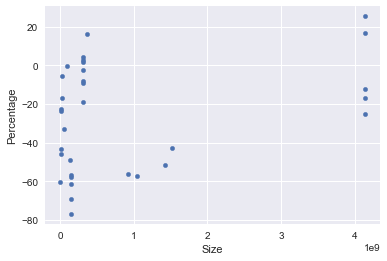

In [21]:
ax = correlation_df_size.plot.scatter(x="Size", y="Percentage")

In [22]:
results_size = statsmodels.formula.api.ols("Percentage ~ Size", data=correlation_df_size).fit()
statsmodels.api.stats.linear_rainbow(results_size)

(2.0751062310601593, 0.08846049648923643)

In [23]:
results_size.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Percentage   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.727
Date:                Fri, 17 Jun 2022   Prob (F-statistic):             0.0630
Time:                        14:49:03   Log-Likelihood:                -149.64
No. Observations:                  32   AIC:                             303.3
Df Residuals:                      30   BIC:                             306.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.5415      5.614     -5.796      0.000     -44.007     -21.076
Size        6.362e-09    3.3e-09      1.931      0.063   -3.68e-10    1.31e-08
==============================================================================
Omnibus:                       11.834   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                2.577
Skew:                           0.050   Prob(JB):                        0.276
Kurtosis:                       1.613   Cond. No.                     2.02e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


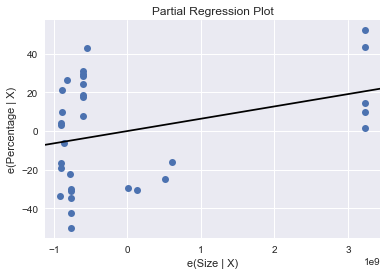

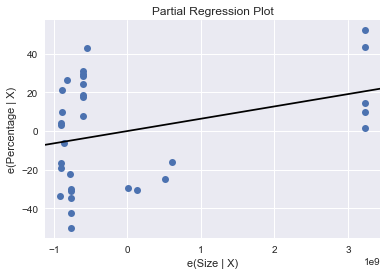

In [24]:
statsmodels.api.graphics.plot_partregress("Percentage", "Size", [], data=correlation_df_size,
                                         obs_labels=False)

In [25]:
# only collect the differences and percentages
correlation_df = scores_df.filter(items=["low_ttr", "high_ttr", "low_mattr", "high_mattr",
                                        "diff_src_low_ttr", "diff_src_high_ttr", "diff_src_low_mattr",
                                        "diff_src_high_mattr"])
correlation_df.reset_index(drop="index", inplace=True)
correlation_df

,low_ttr,high_ttr,low_mattr,high_mattr,diff_src_low_ttr,diff_src_high_ttr,diff_src_low_mattr,diff_src_high_mattr
0,16.22,1.80,-5.41,-25.23,363341187,302400738,18069086,4137891541
1,-33.12,-2.60,-43.51,25.32,50079651,301492097,-1137402,4136982900
2,-51.51,-8.30,-56.98,-76.79,-98290884,-1213444467,-470805654,-1371436428
3,-69.20,-18.75,-56.03,-16.74,-51388217,103567374,719069093,3939058177
4,-60.42,-9.11,-42.73,-61.47,-171846276,131636837,1345081304,-26355124
5,-22.80,4.15,-48.70,-56.74,-8857595,291981373,113795491,133989412
6,-23.56,2.62,-0.52,16.75,1959423,303451520,94409803,4138942323
7,-12.06,-16.72,-45.98,-57.72,3835490803,-284331652,-300838968,-157991961


In [26]:
percentages = pd.concat([correlation_df["low_ttr"], correlation_df["high_ttr"],
          correlation_df["low_mattr"], correlation_df["high_mattr"]],
                       ignore_index=True)

In [27]:
sizes = pd.concat([correlation_df["diff_src_low_ttr"], correlation_df["diff_src_high_ttr"],
                  correlation_df["diff_src_low_mattr"], correlation_df["diff_src_high_mattr"]],
                 ignore_index=True)

In [28]:
correlation_df = pd.concat([percentages, sizes], axis=1).rename(
    columns={0: "Percentage", 1: "Size_difference"})
correlation_df

,Percentage,Size_difference
0,16.22,363341187
1,-33.12,50079651
2,-51.51,-98290884
3,-69.20,-51388217
4,-60.42,-171846276
5,-22.80,-8857595
6,-23.56,1959423
7,-12.06,3835490803
8,1.80,302400738
9,-2.60,301492097


In [29]:
results = statsmodels.formula.api.ols("Percentage ~ Size_difference", data=correlation_df).fit()

In [30]:
statsmodels.api.stats.linear_rainbow(results)

(1.3290691000093258, 0.29930669112021857)

p-value is high enough to confirm the null hypothesis that percentage and size difference do not correlate


(Source: https://www.educba.com/p-value-in-regression/)

In [31]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Percentage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.840
Date:                Fri, 17 Jun 2022   Prob (F-statistic):             0.0138
Time:                        14:49:32   Log-Likelihood:                -148.23
No. Observations:                  32   AIC:                             300.5
Df Residuals:                      30   BIC:                             303.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -31.6517      4.911     -6.445      0.000     -41.682     -21.621
Size_difference  7.732e-09   2.96e-09      2.615      0.014    1.69e-09    1.38e-08
==============================================================================
Omnibus:                       16.508   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.013
Skew:                           0.149   Prob(JB):                        0.222
Kurtosis:                       1.526   Cond. No.                     1.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


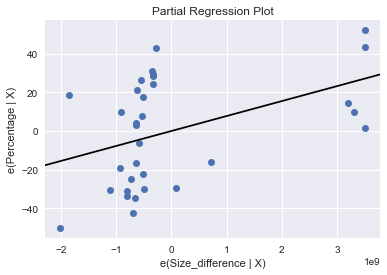

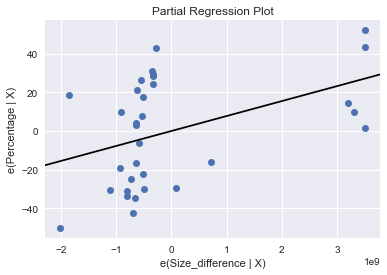

In [32]:
statsmodels.api.graphics.plot_partregress("Percentage", "Size_difference", [], data=correlation_df,
                                         obs_labels=False)

In [68]:
correlation_df

,Percentage,Size_difference,Size difference (in 100K)
0,16.22,363341187,3633
1,-33.12,50079651,501
2,-51.51,-98290884,-983
3,-69.20,-51388217,-514
4,-60.42,-171846276,-1718
5,-22.80,-8857595,-89
6,-23.56,1959423,20
7,-12.06,3835490803,38355
8,1.80,302400738,3024
9,-2.60,301492097,3015


In [67]:
correlation_df["Size difference (in 100K)"] = (round(correlation_df["Size_difference"] / 100_000)).astype(int)

In [75]:
correlation_df["Size (in 100K)"] = correlation_df_size["Size (in 100K)"]
correlation_df

,Percentage,Size_difference,Size difference (in 100K),Size (in 100K)
0,16.22,363341187,3633,3651
1,-33.12,50079651,501,527
2,-51.51,-98290884,-983,14193
3,-69.20,-51388217,-514,1492
4,-60.42,-171846276,-1718,7
5,-22.80,-8857595,-89,33
6,-23.56,1959423,20,26
7,-12.06,3835490803,38355,41396
8,1.80,302400738,3024,3041
9,-2.60,301492097,3015,3041


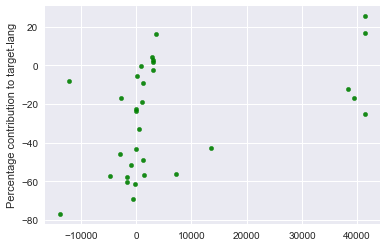

In [95]:
ax = correlation_df.plot.scatter(x="Size difference (in 100K)", y="Percentage", c="green", alpha=0.9,
                                xlabel="", ylabel="Percentage contribution to target-lang")
# correlation_df.plot.scatter(x="Size (in 100K)", y="Percentage", c="red", alpha=0.5,
#                                 xlabel="", ylabel="")

In [100]:
same_script = pd.concat([
    scores_df["same_script_low_ttr"], scores_df["same_script_high_ttr"],
    scores_df["same_script_low_mattr"], scores_df["same_script_high_mattr"]
], ignore_index=True)
same_script

0      NO
1      NO
2     YES
3     YES
4     YES
5     YES
6      NO
7     YES
8      NO
9      NO
10    YES
11    YES
12    YES
13    YES
14    YES
15     NO
16     NO
17    YES
18    YES
19     NO
20    YES
21     NO
22     NO
23    YES
24     NO
25     NO
26     NO
27    YES
28     NO
29     NO
30    YES
31     NO
dtype: object

In [101]:
correlation_df["Same script"] = same_script
correlation_df

,Percentage,Size_difference,Size difference (in 100K),Size (in 100K),Same script
0,16.22,363341187,3633,3651,NO
1,-33.12,50079651,501,527,NO
2,-51.51,-98290884,-983,14193,YES
3,-69.20,-51388217,-514,1492,YES
4,-60.42,-171846276,-1718,7,YES
5,-22.80,-8857595,-89,33,YES
6,-23.56,1959423,20,26,NO
7,-12.06,3835490803,38355,41396,YES
8,1.80,302400738,3024,3041,NO
9,-2.60,301492097,3015,3041,NO


In [106]:
script_group = correlation_df.groupby("Same script")

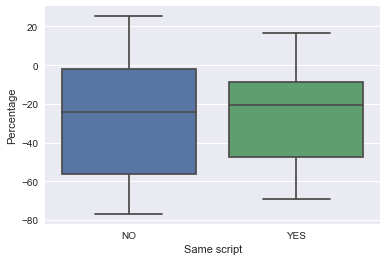

In [123]:
ax = sns.boxplot(x="Same script", y="Percentage", data=correlation_df,
#                  labels=["Not matching script", "Matching script"]
                )

In [124]:
fig = ax.get_figure()
fig.savefig(f"/Users/marcellfekete/Downloads/same_script.pdf")

In [35]:
correlation_df_size["Size (in 100K)"] = (round(correlation_df_size["Size"] / 100_000)).astype(int)
correlation_df_size

,Percentage,Size,Language,Size (in 100K)
0,16.22,365082418,arb,3651
1,-33.12,52729523,est,527
2,-51.51,1419295552,deu,14193
3,-69.20,149186378,fin,1492
4,-60.42,658856,wol,7
5,-22.80,3303001,ilo,33
6,-23.56,2649872,chm,26
7,-12.06,4139632772,eng,41396
8,1.80,304141969,vie,3041
9,-2.60,304141969,vie,3041


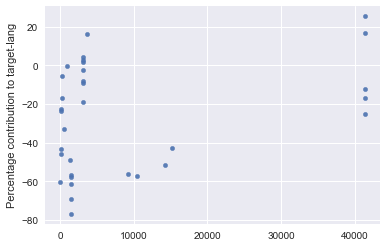

In [58]:
ax = correlation_df_size.plot.scatter(x="Size (in 100K)", y="Percentage",
                                     xlabel="", ylabel="Percentage contribution to target-lang",
                                      alpha=0.9
#                                       c="Size (in 100K)",
#                                      colormap="winter"
                                     )

In [59]:
fig = ax.get_figure()
fig.savefig(f"/Users/marcellfekete/Downloads/interaction_of_contribution_size.pdf")

### We can try to get rid of outliers and rerun the calculations

In [37]:
correlation_df.describe()

,Percentage,Size_difference
count,32.00000,3.200000e+01
mean,-26.74500,6.345614e+08
std,27.98946,1.559694e+09
min,-76.79000,-1.371436e+09
25%,-52.64000,-6.311388e+07
50%,-23.18000,9.898859e+07
75%,-4.70750,3.184239e+08
max,25.32000,4.138942e+09


In [38]:
q1 = correlation_df.quantile(0.25)

In [39]:
q3 = correlation_df.quantile(0.75)

In [40]:
IQR = q3-q1

In [41]:
not_outliers = correlation_df[~((correlation_df<(q1-1.5*IQR)) | (correlation_df>(q3+1.5*IQR)))]

In [42]:
outliers_dropped = not_outliers.dropna().reset_index(drop="index")
outliers_dropped

,Percentage,Size_difference
0,16.22,363341187.0
1,-33.12,50079651.0
2,-51.51,-98290884.0
3,-69.20,-51388217.0
4,-60.42,-171846276.0
5,-22.80,-8857595.0
6,-23.56,1959423.0
7,1.80,302400738.0
8,-2.60,301492097.0
9,-18.75,103567374.0


In [43]:
results = statsmodels.formula.api.ols("Percentage ~ Size_difference", data=outliers_dropped).fit()

In [44]:
statsmodels.api.stats.linear_rainbow(results)

(1.2833623174076494, 0.3511702130669765)

Even after dropping outliers before and after Q1 (0.25) and Q3 (0.75), the two variables (percentage and data size) do not seem to depend on each other,

eval_env: 1


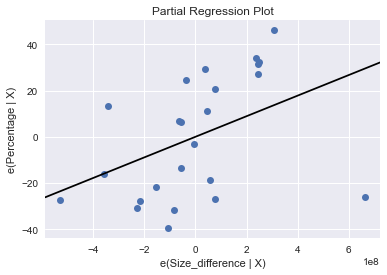

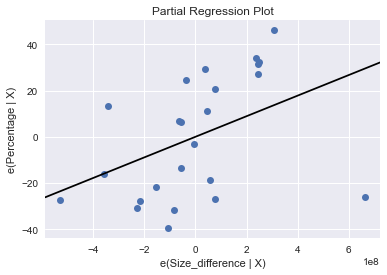

In [45]:
statsmodels.api.graphics.plot_partregress("Percentage", "Size_difference", [], data=outliers_dropped,
                                         obs_labels=False)

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Percentage   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     4.857
Date:                Fri, 17 Jun 2022   Prob (F-statistic):             0.0383
Time:                        14:50:24   Log-Likelihood:                -109.72
No. Observations:                  24   AIC:                             223.4
Df Residuals:                      22   BIC:                             225.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -32.3536      5.117     -6.323      0.000     -42.966     -21.742
Size_difference  4.452e-08   2.02e-08      2.204      0.038    2.62e-09    8.64e-08
==============================================================================
Omnibus:                        1.634   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                1.450
Skew:                          -0.500   Prob(JB):                        0.484
Kurtosis:                       2.328   Cond. No.                     2.60e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""